# Exploit Results - Exploratory Data Analysis

This notebook analyzes the benchmark results from the yudai-swe-agent exploit generation runs.

In [1]:
import json
import glob
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Data Loading and Preprocessing

In [2]:
# Get all main benchmark JSON files (excluding trajectory and result files)
files = sorted(glob.glob('exploit_results/benchmark_*.json'))
files = [f for f in files if '.traj.' not in f and '.result.' not in f]

print(f"Found {len(files)} benchmark result files")

# Load all data
all_data = []
for file_path in files:
    with open(file_path, 'r') as f:
        data = json.load(f)
        all_data.append(data)

print(f"Loaded {len(all_data)} benchmark runs")

Found 28 benchmark result files
Loaded 28 benchmark runs


In [3]:
# Create a flat dataframe with all cases
records = []

for run in all_data:
    run_id = run.get('run_id', '')
    run_status = run.get('status', 'unknown')
    model = run.get('settings', {}).get('model_name', 'unknown')
    cost_limit = run.get('settings', {}).get('cost_limit', None)
    
    started_at = run.get('started_at')
    finished_at = run.get('finished_at')
    
    for case in run.get('cases', []):
        record = {
            'run_id': run_id,
            'run_status': run_status,
            'model': model,
            'cost_limit': cost_limit,
            'started_at': started_at,
            'finished_at': finished_at,
            'case_name': case.get('case_name', ''),
            'chain': case.get('chain', 'unknown'),
            'fork_block_number': case.get('fork_block_number'),
            'status': case.get('status', 'unknown'),
            'duration_sec': case.get('duration_sec'),
            'episode_id': case.get('episode_id', ''),
            'error_type': case.get('error', {}).get('type') if case.get('error') else None,
            'error_message': case.get('error', {}).get('message') if case.get('error') else None,
            'source_length': case.get('source_length'),
            'metrics': case.get('metrics', {})
        }
        records.append(record)

df = pd.DataFrame(records)

# Convert datetime columns
df['started_at'] = pd.to_datetime(df['started_at'])
df['finished_at'] = pd.to_datetime(df['finished_at'])
df['date'] = df['started_at'].dt.date

print(f"\nDataFrame shape: {df.shape}")
df.head()


DataFrame shape: (28, 17)


,run_id,run_status,model,cost_limit,started_at,finished_at,case_name,chain,fork_block_number,status,duration_sec,episode_id,error_type,error_message,source_length,metrics,date
0,benchmark_20260125_205416_67252,interrupted,google/gemini-3-flash-preview,10.0,2026-01-25 15:24:16+00:00,2026-01-25 15:44:33+00:00,bancor,mainnet,10307563,interrupted,1217.312,benchmark_20260125_205416_67252_1_bancor,KeyboardInterrupt,Run interrupted by user,57237,{},2026-01-25
1,benchmark_20260125_212401_70644,interrupted,google/gemini-3-flash-preview,10.0,2026-01-25 15:54:01+00:00,2026-01-25 15:57:19+00:00,pickle,mainnet,11303122,interrupted,198.695,benchmark_20260125_212401_70644_1_pickle,KeyboardInterrupt,Run interrupted by user,345363,{},2026-01-25
2,benchmark_20260125_215536_72918,interrupted,google/gemini-3-flash-preview,10.0,2026-01-25 16:25:36+00:00,2026-01-25 16:27:14+00:00,brahtopg,mainnet,15933794,interrupted,98.561,benchmark_20260125_215536_72918_1_brahtopg,KeyboardInterrupt,Run interrupted by user,30187,{},2026-01-25
3,benchmark_20260125_220200_74378,interrupted,google/gemini-3-flash-preview,10.0,2026-01-25 16:32:00+00:00,2026-01-25 16:37:15+00:00,sdao,bsc,23241440,interrupted,314.602,benchmark_20260125_220200_74378_1_sdao,KeyboardInterrupt,Run interrupted by user,16562,{},2026-01-25
4,benchmark_20260125_221531_76273,interrupted,deepseek/deepseek-v3.2,10.0,2026-01-25 16:45:31+00:00,2026-01-25 16:57:59+00:00,sdao,bsc,23241440,interrupted,747.989,benchmark_20260125_221531_76273_1_sdao,KeyboardInterrupt,Run interrupted by user,16562,{},2026-01-25


In [4]:
# Display basic statistics
print("=" * 60)
print("BASIC STATISTICS")
print("=" * 60)

print(f"\nTotal benchmark runs: {len(all_data)}")
print(f"Total cases executed: {len(df)}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nUnique models tested: {df['model'].nunique()}")
print(f"Unique chains: {df['chain'].nunique()}")
print(f"Unique cases: {df['case_name'].nunique()}")

BASIC STATISTICS

Total benchmark runs: 28
Total cases executed: 28

Date range: 2026-01-25 to 2026-02-01

Unique models tested: 3
Unique chains: 2
Unique cases: 24


## 2. Status Distribution Analysis

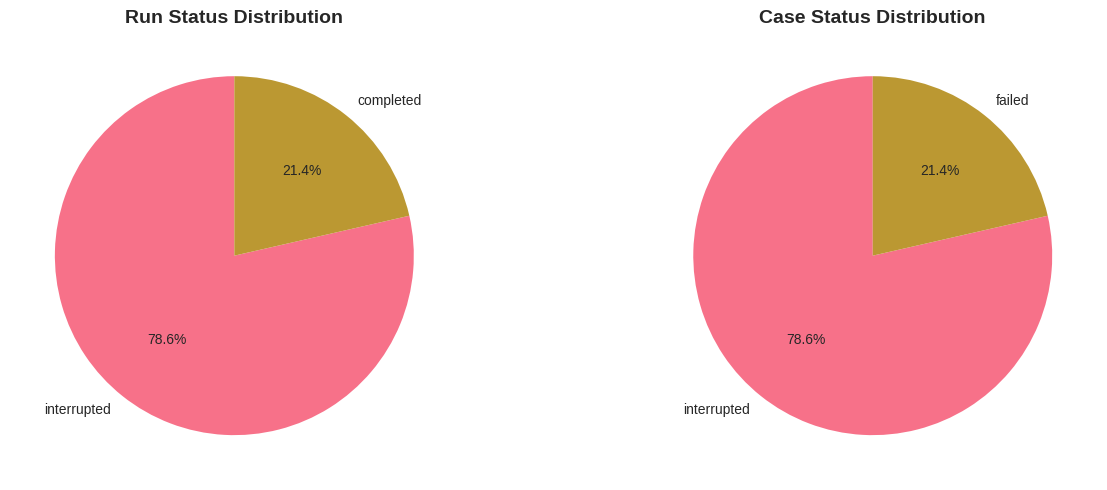


Run Status:
run_status
interrupted    22
completed       6
Name: count, dtype: int64

Case Status:
status
interrupted    22
failed          6
Name: count, dtype: int64


In [5]:
# Status distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Run status
run_status_counts = df['run_status'].value_counts()
axes[0].pie(run_status_counts.values, labels=run_status_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Run Status Distribution', fontsize=14, fontweight='bold')

# Case status
case_status_counts = df['status'].value_counts()
axes[1].pie(case_status_counts.values, labels=case_status_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Case Status Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nRun Status:")
print(run_status_counts)
print("\nCase Status:")
print(case_status_counts)

## 3. Model Performance Analysis

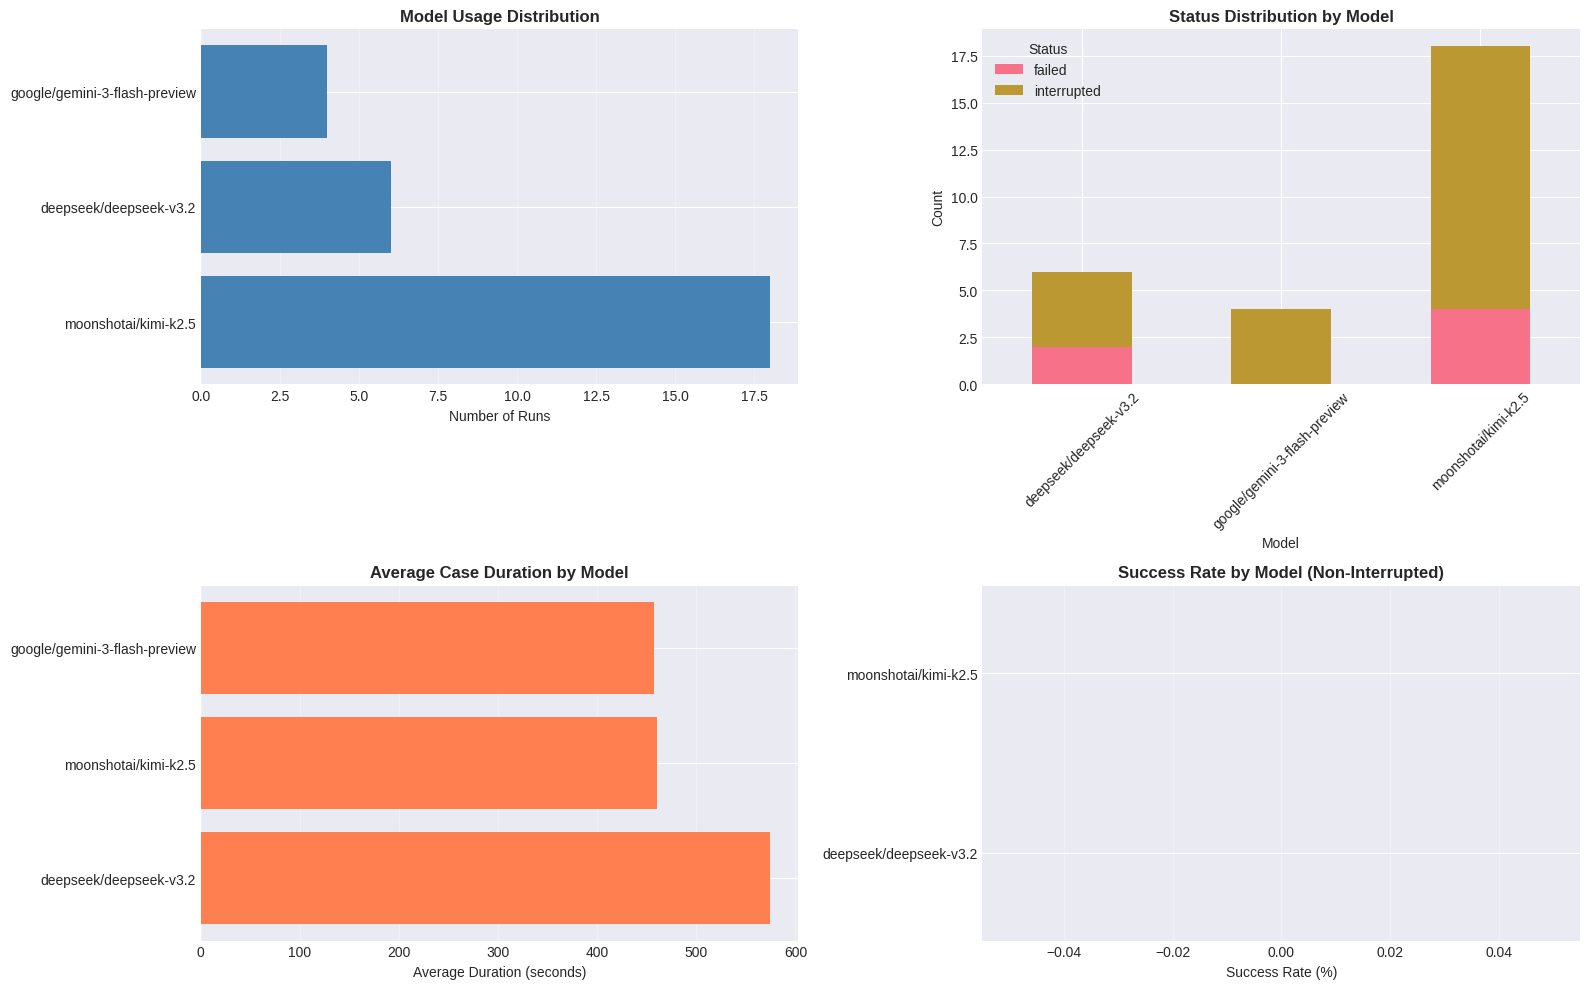

In [6]:
# Model usage and performance
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Model usage count
model_counts = df['model'].value_counts()
axes[0, 0].barh(model_counts.index, model_counts.values, color='steelblue')
axes[0, 0].set_xlabel('Number of Runs')
axes[0, 0].set_title('Model Usage Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Status by model
status_by_model = pd.crosstab(df['model'], df['status'])
status_by_model.plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Status Distribution by Model', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(title='Status')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average duration by model
avg_duration = df.groupby('model')['duration_sec'].mean().sort_values(ascending=False)
axes[1, 0].barh(avg_duration.index, avg_duration.values, color='coral')
axes[1, 0].set_xlabel('Average Duration (seconds)')
axes[1, 0].set_title('Average Case Duration by Model', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Success rate by model (excluding interrupted)
completed_df = df[df['status'].isin(['completed', 'failed', 'success'])]
if len(completed_df) > 0:
    model_success = completed_df.groupby('model')['status'].apply(
        lambda x: (x == 'success').sum() / len(x) * 100
    ).sort_values(ascending=False)
    axes[1, 1].barh(model_success.index, model_success.values, color='lightgreen')
    axes[1, 1].set_xlabel('Success Rate (%)')
    axes[1, 1].set_title('Success Rate by Model (Non-Interrupted)', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No completed runs', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Success Rate by Model', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Chain Analysis

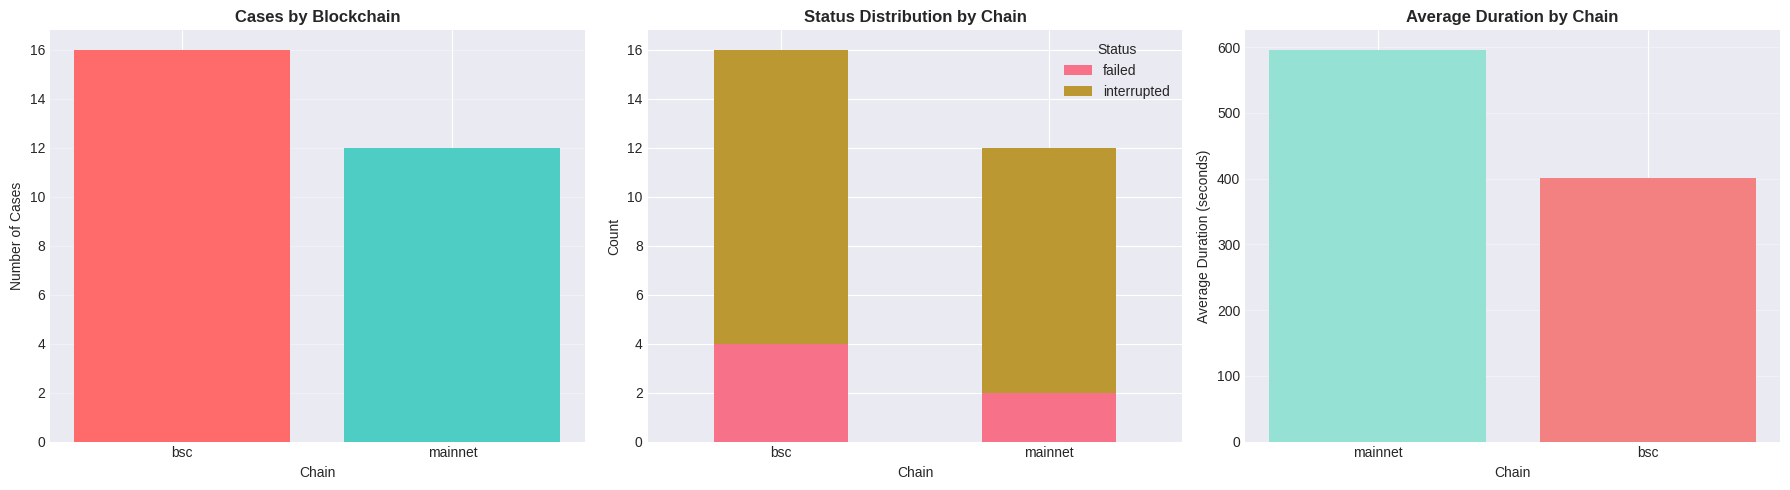


Chain Statistics:
        duration_sec                                source_length          
               count    mean     std    min     max          mean       std
chain                                                                      
bsc               16  400.32  266.16   8.17   905.9      26040.62  12242.62
mainnet           12  595.84  529.93  11.58  1713.3      84745.08  93199.16


In [7]:
# Chain distribution and performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Chain distribution
chain_counts = df['chain'].value_counts()
axes[0].bar(chain_counts.index, chain_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_xlabel('Chain')
axes[0].set_ylabel('Number of Cases')
axes[0].set_title('Cases by Blockchain', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Status by chain
status_by_chain = pd.crosstab(df['chain'], df['status'])
status_by_chain.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Status Distribution by Chain', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Chain')
axes[1].set_ylabel('Count')
axes[1].legend(title='Status')
axes[1].tick_params(axis='x', rotation=0)

# Average duration by chain
avg_duration_chain = df.groupby('chain')['duration_sec'].mean().sort_values(ascending=False)
axes[2].bar(avg_duration_chain.index, avg_duration_chain.values, color=['#95E1D3', '#F38181'])
axes[2].set_xlabel('Chain')
axes[2].set_ylabel('Average Duration (seconds)')
axes[2].set_title('Average Duration by Chain', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nChain Statistics:")
print(df.groupby('chain').agg({
    'duration_sec': ['count', 'mean', 'std', 'min', 'max'],
    'source_length': ['mean', 'std']
}).round(2))

## 5. Duration Analysis

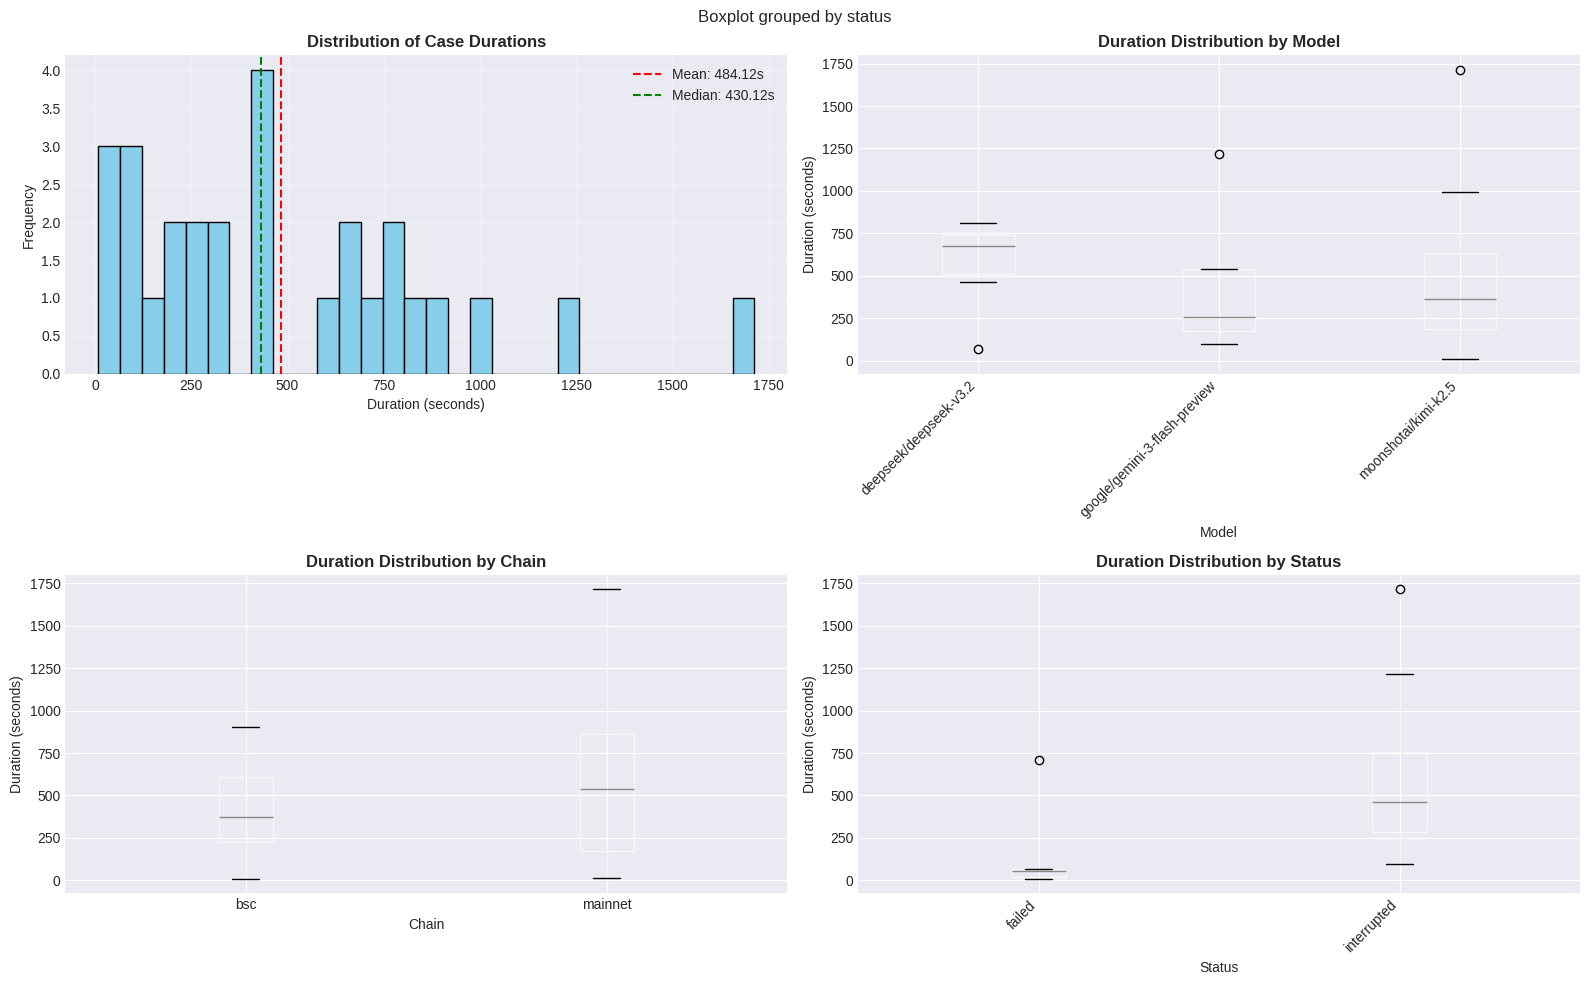


Duration Statistics:
count      28.000000
mean      484.115750
std       404.322067
min         8.172000
25%       192.628500
50%       430.124500
75%       718.732250
max      1713.305000
Name: duration_sec, dtype: float64


In [8]:
# Duration analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram of durations
axes[0, 0].hist(df['duration_sec'].dropna(), bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Duration (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Case Durations', fontsize=12, fontweight='bold')
axes[0, 0].axvline(df['duration_sec'].mean(), color='red', linestyle='--', label=f'Mean: {df["duration_sec"].mean():.2f}s')
axes[0, 0].axvline(df['duration_sec'].median(), color='green', linestyle='--', label=f'Median: {df["duration_sec"].median():.2f}s')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot by model
df.boxplot(column='duration_sec', by='model', ax=axes[0, 1])
axes[0, 1].set_title('Duration Distribution by Model', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Duration (seconds)')
plt.sca(axes[0, 1])
plt.xticks(rotation=45, ha='right')

# Box plot by chain
df.boxplot(column='duration_sec', by='chain', ax=axes[1, 0])
axes[1, 0].set_title('Duration Distribution by Chain', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Chain')
axes[1, 0].set_ylabel('Duration (seconds)')

# Box plot by status
df.boxplot(column='duration_sec', by='status', ax=axes[1, 1])
axes[1, 1].set_title('Duration Distribution by Status', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Status')
axes[1, 1].set_ylabel('Duration (seconds)')
plt.sca(axes[1, 1])
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nDuration Statistics:")
print(df['duration_sec'].describe())

## 6. Error Analysis

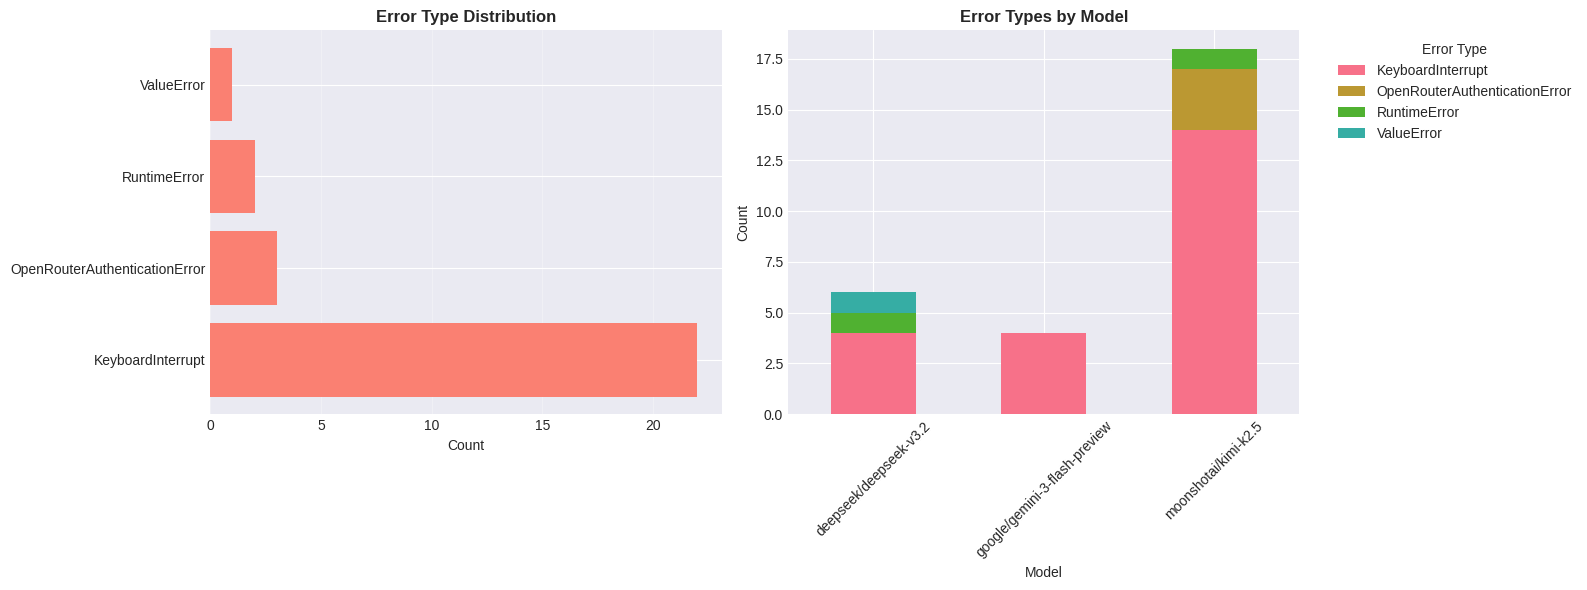


Error Type Summary:
error_type
KeyboardInterrupt                22
OpenRouterAuthenticationError     3
RuntimeError                      2
ValueError                        1
Name: count, dtype: int64

Sample Error Messages:

KeyboardInterrupt:
  Run interrupted by user

OpenRouterAuthenticationError:
  Authentication failed. You can permanently set your API key with `mini-extra config set OPENROUTER_API_KEY YOUR_KEY`.

RuntimeError:
  Anvil process is running but not responding to RPC after 60s.

This may indicate:
  - Very slow fork initialization (try increasing timeout)
  - Network issues connecting to the RPC endpoint
  - RPC r...


In [9]:
# Error type analysis
error_df = df[df['error_type'].notna()].copy()

if len(error_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Error type distribution
    error_counts = error_df['error_type'].value_counts()
    axes[0].barh(error_counts.index, error_counts.values, color='salmon')
    axes[0].set_xlabel('Count')
    axes[0].set_title('Error Type Distribution', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Error types by model
    error_by_model = pd.crosstab(error_df['model'], error_df['error_type'])
    error_by_model.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title('Error Types by Model', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Count')
    axes[1].legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nError Type Summary:")
    print(error_counts)
    
    print("\nSample Error Messages:")
    for error_type in error_counts.head(3).index:
        sample = error_df[error_df['error_type'] == error_type]['error_message'].iloc[0]
        print(f"\n{error_type}:")
        print(f"  {sample[:200]}..." if len(sample) > 200 else f"  {sample}")
else:
    print("No errors found in the dataset")

## 7. Time Series Analysis

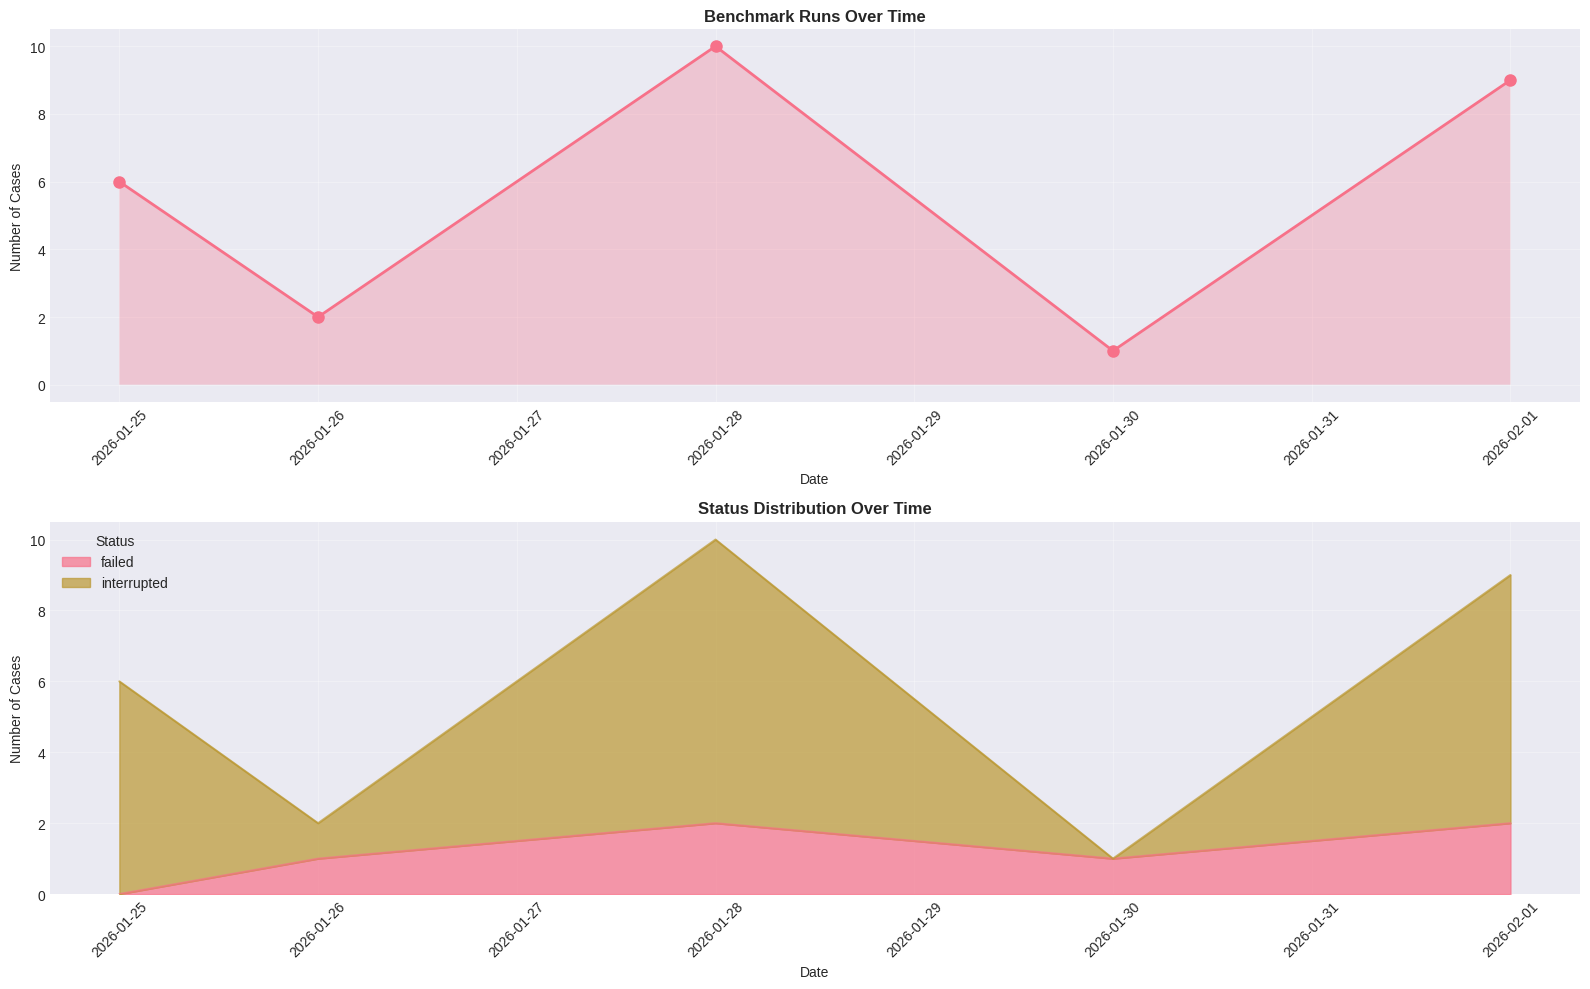

In [10]:
# Time series analysis
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Runs over time
runs_per_day = df.groupby('date').size()
axes[0].plot(runs_per_day.index, runs_per_day.values, marker='o', linewidth=2, markersize=8)
axes[0].fill_between(runs_per_day.index, runs_per_day.values, alpha=0.3)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Cases')
axes[0].set_title('Benchmark Runs Over Time', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Status over time
status_over_time = df.groupby(['date', 'status']).size().unstack(fill_value=0)
status_over_time.plot(kind='area', stacked=True, ax=axes[1], alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Cases')
axes[1].set_title('Status Distribution Over Time', fontsize=12, fontweight='bold')
axes[1].legend(title='Status')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Source Code Length Analysis

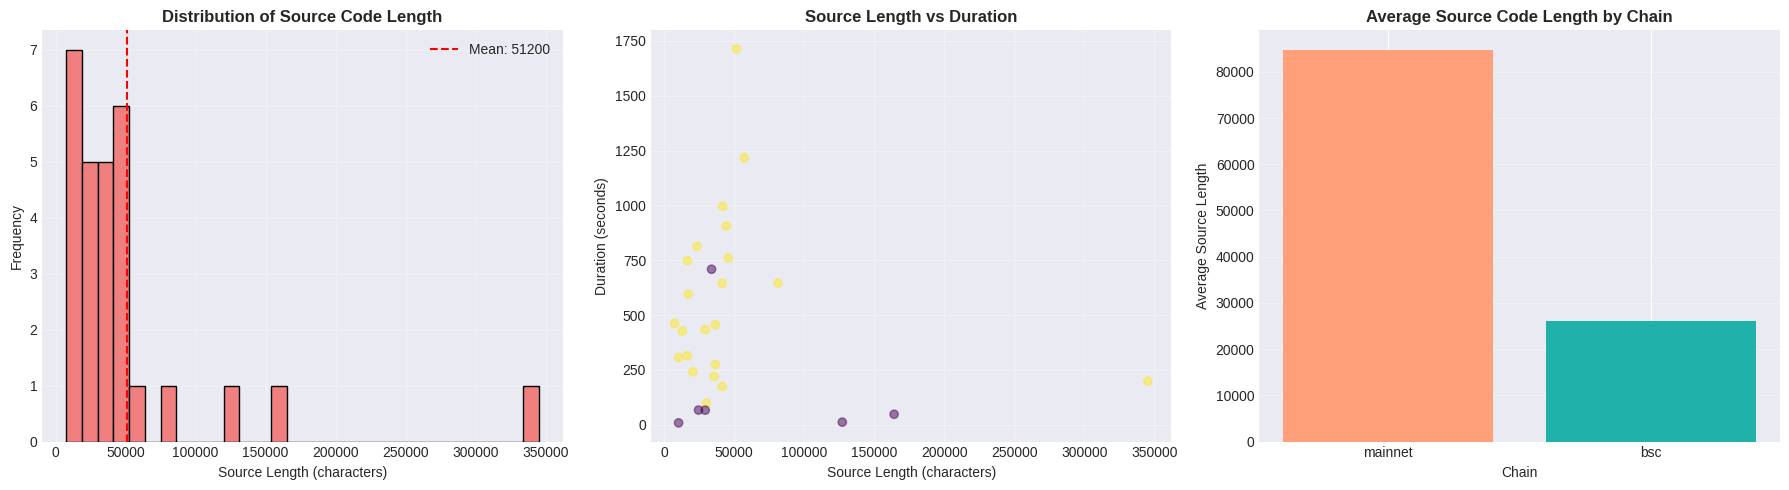


Source Length Statistics:
count        28.000000
mean      51199.678571
std       67061.695268
min        7415.000000
25%       19720.750000
50%       34814.000000
75%       44795.250000
max      345363.000000
Name: source_length, dtype: float64


In [11]:
# Source length analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution of source lengths
axes[0].hist(df['source_length'].dropna(), bins=30, color='lightcoral', edgecolor='black')
axes[0].set_xlabel('Source Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Source Code Length', fontsize=12, fontweight='bold')
axes[0].axvline(df['source_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["source_length"].mean():.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Source length vs duration scatter
valid_data = df[df['source_length'].notna() & df['duration_sec'].notna()]
axes[1].scatter(valid_data['source_length'], valid_data['duration_sec'], alpha=0.5, c=valid_data['status'].astype('category').cat.codes, cmap='viridis')
axes[1].set_xlabel('Source Length (characters)')
axes[1].set_ylabel('Duration (seconds)')
axes[1].set_title('Source Length vs Duration', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# Average source length by chain
avg_source_length = df.groupby('chain')['source_length'].mean().sort_values(ascending=False)
axes[2].bar(avg_source_length.index, avg_source_length.values, color=['#FFA07A', '#20B2AA'])
axes[2].set_xlabel('Chain')
axes[2].set_ylabel('Average Source Length')
axes[2].set_title('Average Source Code Length by Chain', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSource Length Statistics:")
print(df['source_length'].describe())

## 9. Case-Level Analysis

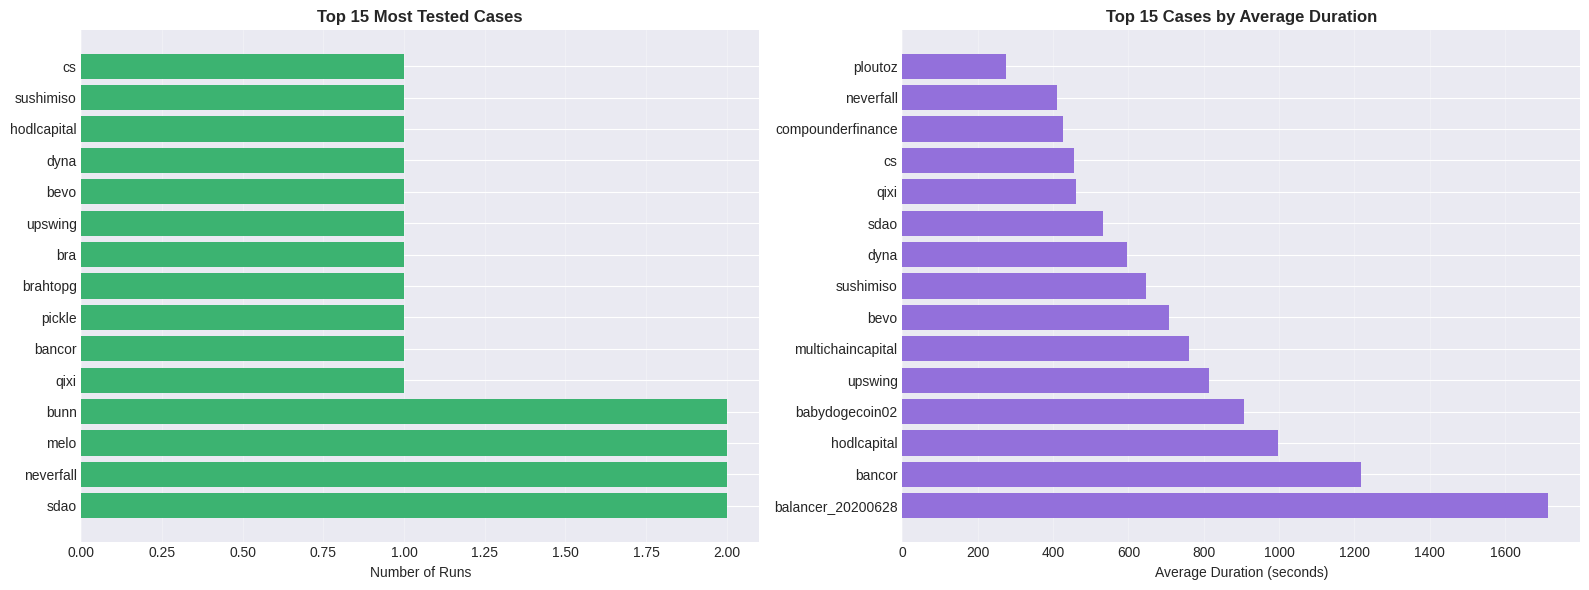


Total unique cases: 24

Most tested cases:
case_name
sdao           2
neverfall      2
melo           2
bunn           2
qixi           1
bancor         1
pickle         1
brahtopg       1
bra            1
upswing        1
bevo           1
dyna           1
hodlcapital    1
sushimiso      1
cs             1
Name: count, dtype: int64


In [12]:
# Top cases by frequency
case_counts = df['case_name'].value_counts().head(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Most tested cases
axes[0].barh(case_counts.index, case_counts.values, color='mediumseagreen')
axes[0].set_xlabel('Number of Runs')
axes[0].set_title('Top 15 Most Tested Cases', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Average duration per case (top 15)
avg_duration_case = df.groupby('case_name')['duration_sec'].mean().sort_values(ascending=False).head(15)
axes[1].barh(avg_duration_case.index, avg_duration_case.values, color='mediumpurple')
axes[1].set_xlabel('Average Duration (seconds)')
axes[1].set_title('Top 15 Cases by Average Duration', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal unique cases: {df['case_name'].nunique()}")
print(f"\nMost tested cases:")
print(case_counts)

## 10. Summary Statistics

In [13]:
# Comprehensive summary
print("="*80)
print("COMPREHENSIVE SUMMARY")
print("="*80)

print(f"\n📊 Overall Statistics:")
print(f"  • Total benchmark runs: {len(all_data)}")
print(f"  • Total cases executed: {len(df)}")
print(f"  • Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  • Unique cases: {df['case_name'].nunique()}")
print(f"  • Unique models: {df['model'].nunique()}")
print(f"  • Unique chains: {df['chain'].nunique()}")

print(f"\n✅ Status Breakdown:")
for status, count in df['status'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  • {status}: {count} ({percentage:.1f}%)")

print(f"\n🤖 Model Usage:")
for model, count in df['model'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  • {model}: {count} ({percentage:.1f}%)")

print(f"\n⛓️ Chain Distribution:")
for chain, count in df['chain'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  • {chain}: {count} ({percentage:.1f}%)")

print(f"\n⏱️ Duration Statistics:")
print(f"  • Mean: {df['duration_sec'].mean():.2f} seconds")
print(f"  • Median: {df['duration_sec'].median():.2f} seconds")
print(f"  • Min: {df['duration_sec'].min():.2f} seconds")
print(f"  • Max: {df['duration_sec'].max():.2f} seconds")
print(f"  • Total time: {df['duration_sec'].sum() / 3600:.2f} hours")

print(f"\n⚠️ Error Statistics:")
error_counts = df['error_type'].value_counts()
if len(error_counts) > 0:
    for error_type, count in error_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  • {error_type}: {count} ({percentage:.1f}%)")
else:
    print("  • No errors recorded")

print(f"\n📝 Source Code Statistics:")
print(f"  • Mean length: {df['source_length'].mean():.0f} characters")
print(f"  • Median length: {df['source_length'].median():.0f} characters")
print(f"  • Min length: {df['source_length'].min():.0f} characters")
print(f"  • Max length: {df['source_length'].max():.0f} characters")

print("\n" + "="*80)

COMPREHENSIVE SUMMARY

📊 Overall Statistics:
  • Total benchmark runs: 28
  • Total cases executed: 28
  • Date range: 2026-01-25 to 2026-02-01
  • Unique cases: 24
  • Unique models: 3
  • Unique chains: 2

✅ Status Breakdown:
  • interrupted: 22 (78.6%)
  • failed: 6 (21.4%)

🤖 Model Usage:
  • moonshotai/kimi-k2.5: 18 (64.3%)
  • deepseek/deepseek-v3.2: 6 (21.4%)
  • google/gemini-3-flash-preview: 4 (14.3%)

⛓️ Chain Distribution:
  • bsc: 16 (57.1%)
  • mainnet: 12 (42.9%)

⏱️ Duration Statistics:
  • Mean: 484.12 seconds
  • Median: 430.12 seconds
  • Min: 8.17 seconds
  • Max: 1713.31 seconds
  • Total time: 3.77 hours

⚠️ Error Statistics:
  • KeyboardInterrupt: 22 (78.6%)
  • OpenRouterAuthenticationError: 3 (10.7%)
  • RuntimeError: 2 (7.1%)
  • ValueError: 1 (3.6%)

📝 Source Code Statistics:
  • Mean length: 51200 characters
  • Median length: 34814 characters
  • Min length: 7415 characters
  • Max length: 345363 characters



## 11. Detailed DataFrame View

In [14]:
# Display the full dataframe
print("Full DataFrame:")
df

Full DataFrame:


,run_id,run_status,model,cost_limit,started_at,finished_at,case_name,chain,fork_block_number,status,duration_sec,episode_id,error_type,error_message,source_length,metrics,date
0,benchmark_20260125_205416_67252,interrupted,google/gemini-3-flash-preview,10.0,2026-01-25 15:24:16+00:00,2026-01-25 15:44:33+00:00,bancor,mainnet,10307563,interrupted,1217.312,benchmark_20260125_205416_67252_1_bancor,KeyboardInterrupt,Run interrupted by user,57237,{},2026-01-25
1,benchmark_20260125_212401_70644,interrupted,google/gemini-3-flash-preview,10.0,2026-01-25 15:54:01+00:00,2026-01-25 15:57:19+00:00,pickle,mainnet,11303122,interrupted,198.695,benchmark_20260125_212401_70644_1_pickle,KeyboardInterrupt,Run interrupted by user,345363,{},2026-01-25
2,benchmark_20260125_215536_72918,interrupted,google/gemini-3-flash-preview,10.0,2026-01-25 16:25:36+00:00,2026-01-25 16:27:14+00:00,brahtopg,mainnet,15933794,interrupted,98.561,benchmark_20260125_215536_72918_1_brahtopg,KeyboardInterrupt,Run interrupted by user,30187,{},2026-01-25
3,benchmark_20260125_220200_74378,interrupted,google/gemini-3-flash-preview,10.0,2026-01-25 16:32:00+00:00,2026-01-25 16:37:15+00:00,sdao,bsc,23241440,interrupted,314.602,benchmark_20260125_220200_74378_1_sdao,KeyboardInterrupt,Run interrupted by user,16562,{},2026-01-25
4,benchmark_20260125_221531_76273,interrupted,deepseek/deepseek-v3.2,10.0,2026-01-25 16:45:31+00:00,2026-01-25 16:57:59+00:00,sdao,bsc,23241440,interrupted,747.989,benchmark_20260125_221531_76273_1_sdao,KeyboardInterrupt,Run interrupted by user,16562,{},2026-01-25
5,benchmark_20260125_222146_77358,interrupted,deepseek/deepseek-v3.2,10.0,2026-01-25 16:51:46+00:00,2026-01-25 16:59:28+00:00,qixi,bsc,20120884,interrupted,462.037,benchmark_20260125_222146_77358_1_qixi,KeyboardInterrupt,Run interrupted by user,7415,{},2026-01-25
6,benchmark_20260126_162148_81167,completed,deepseek/deepseek-v3.2,10.0,2026-01-26 10:51:48+00:00,2026-01-26 11:03:37+00:00,bevo,bsc,25230702,failed,708.980,benchmark_20260126_162148_81167_1_bevo,ValueError,invalid literal for int() with base 10: '',33865,{},2026-01-26
7,benchmark_20260126_164932_83729,interrupted,deepseek/deepseek-v3.2,10.0,2026-01-26 11:19:32+00:00,2026-01-26 11:33:06+00:00,upswing,mainnet,16433820,interrupted,814.033,benchmark_20260126_164932_83729_1_upswing,KeyboardInterrupt,Run interrupted by user,23480,{},2026-01-26
8,benchmark_20260128_193202_95252,interrupted,moonshotai/kimi-k2.5,10.0,2026-01-28 14:02:02+00:00,2026-01-28 14:06:04+00:00,bra,bsc,24655771,interrupted,241.328,benchmark_20260128_193202_95252_1_bra,KeyboardInterrupt,Run interrupted by user,20513,{},2026-01-28
9,benchmark_20260128_194246_96963,interrupted,moonshotai/kimi-k2.5,10.0,2026-01-28 14:12:46+00:00,2026-01-28 14:22:41+00:00,dyna,bsc,25879486,interrupted,595.011,benchmark_20260128_194246_96963_1_dyna,KeyboardInterrupt,Run interrupted by user,17344,{},2026-01-28


In [15]:
# Export summary to CSV for further analysis
output_file = 'exploit_results/benchmark_summary.csv'
df.to_csv(output_file, index=False)
print(f"Summary exported to: {output_file}")

Summary exported to: exploit_results/benchmark_summary.csv
